# Statistical analysis of the taxonomical profiles



At this point, you should have computed taxonomic profiles of the metagenome samples using at least one of MetaPhlAn4 or Kraken2. We will now try to use this information to compare the profiles between the two sites/countries. In this notebook, we will limit ourselves to visualizig the differences using a PCA plot. Given the format of the output of the taxonomic profiling step, there is a bit of massaging that needs to be done to the data, before we can get it into a format amenable to pass to a PCA plotter. Much of the code below is just doing this massaging.

We will be using R, and RStudio provides the best environment for working with R. However, we will continue to use Jupyter Notebook so that we don't have to switch environments. 

### Loading the libraries
Let's begin by loading the necessary R libraries. These are already available to you in the container.

In [1]:
library (ggplot2)
library(tidyr)
library(stringr)
library(vegan)
library(plotly)
library(ggfortify)
library(compositions)
library(ggrepel)
library(tidyverse)

Loading required package: permute

Loading required package: lattice

This is vegan 2.6-8


Attaching package: 'plotly'


The following object is masked from 'package:ggplot2':

    last_plot


The following object is masked from 'package:stats':

    filter


The following object is masked from 'package:graphics':

    layout


Welcome to compositions, a package for compositional data analysis.
Find an intro with "? compositions"



Attaching package: 'compositions'


The following objects are masked from 'package:stats':

    anova, cor, cov, dist, var


The following object is masked from 'package:graphics':

    segments


The following objects are masked from 'package:base':

    %*%, norm, scale, scale.default


-- Attaching core tidyverse packages ----------------------------------------------------------------------------------------------------- tidyverse 2.0.0 --
v dplyr     1.1.4     v purrr     1.0.2
v forcats   1.0.0     v readr     2.1.5
v lubridate 1.9.4     v tibble    

### Loading abundance data

Let's load the metadata of the samples, although there is not much information in our down-sampled toy dataset.

In [1]:

metadata <- read.table("data/metagenome_samples/metadata.txt", sep = "\t", header = TRUE)



In [2]:
metadata

SampleID,country
<chr>,<chr>
BH1,Benin
BH2,Benin
BH3,Benin
BH4,Benin
FH1,Finland
FH2,Finland
FH3,Finland
FH4,Finland


Here we will use the abundances obtained by using the Kraken2-Bracken combination. The same steps apply for MetaPhlAn4.

Let's load the abundance table as a dataframe.

In [16]:

kraken_data <- read.delim("results/kraken2_output/merged_kraken_abundance_table.txt",header = TRUE)

### Data massaging

#### Reshaping
Let's begin the massage. First, let's change the shape of this dataframe by running the code below which does the following.

1. Converts a dataset (`kraken_data`) from **wide** format to **long** format using `pivot_longer`.

From Wide Format (Original Metaphlan Results):
| ID   | Sample1 | Sample2 | Sample3 |
|------|---------|---------|---------|
| Taxa1 | 0.5     | 0.3     | 0.2     |
| Taxa2 | 0.2     | 0.1     | 0.4     |
| Taxa3 | 0.3     | 0.6     | 0.4     |


To Long Format 
| ID   | SampleID | RelativeAbundance |
|------|----------|-------------------|
| Taxa1 | Sample1  | 0.5               |
| Taxa1 | Sample2  | 0.3               |
| Taxa1 | Sample3  | 0.2               |
| Taxa2 | Sample1  | 0.2               |
| Taxa2 | Sample2  | 0.1               |
| Taxa2 | Sample3  | 0.4               |
| Taxa3 | Sample1  | 0.3               |
| Taxa3 | Sample2  | 0.6               |
| Taxa3 | Sample3  | 0.4               |

2. Merges the reshaped data with another dataset (`metadata`) based on a common key, `SampleID`.

In [29]:
kraken_with_metadata <- kraken_data %>%
   pivot_longer(cols = -ID, names_to = "SampleID", values_to = "RelativeAbundance") %>%
   merge(metadata, by = "SampleID", all.x = TRUE)

Let's check out the resulting dataframe.

In [18]:
head(kraken_with_metadata)

,SampleID,ID,RelativeAbundance,country
,<chr>,<chr>,<dbl>,<chr>
1,BH1,d__Archaea,0.016718800,Benin
2,BH1,d__Bacteria|p__Actinomycetota|c__Actinomycetes|o__Micrococcales|f__Microbacteriaceae|g__Salinibacterium,0.000000000,Benin
3,BH1,d__Bacteria|p__Bacillota|c__Clostridia|o__Eubacteriales|f__Acutalibacteraceae|g__Caproicibacter,0.000000000,Benin
4,BH1,d__Archaea|p__Euryarchaeota|c__Methanonatronarchaeia|o__Methanonatronarchaeales,0.000000000,Benin
5,BH1,d__Bacteria|p__Actinomycetota|c__Actinomycetes|o__Streptosporangiales|f__Nocardiopsaceae|g__Spiractinospora,0.000283369,Benin
6,BH1,d__Bacteria|p__Bacillota|c__Clostridia|o__Lachnospirales|f__Lachnospiraceae|g__Pseudobutyrivibrio,0.000000000,Benin


#### Adding Taxonomic Information
The taxonomic ID in the dataset typically includes hierarchical information in a format like:

`k__Bacteria|p__Firmicutes|c__Clostridia`

This is a hierarchical string, where each part represents a taxonomic rank (e.g., Kingdom, Phylum, Class, etc.). 

For example:

- `k__Bacteria`: Represents Kingdom
- `p__Firmicutes`: Represents Phylum
- `c__Clostridia`: Represents Class


However, in many cases, only the most specific taxonomic rank (like Genus or Species) is of interest. To focus on this specific label, we need to extract the last part of the string (the most specific taxonomic level).

For example:

- Original: `k__Bacteria|p__Firmicutes|c__Clostridia`
- Extracted: Clostridia

This allows you to work with, e.g. species names, rather than the entire hierarchical string.

In [31]:
# Add taxonomic information (level and label)
kraken_with_metadata$Taxonomic_Level <- sapply(strsplit(as.character(kraken_with_metadata$ID), "\\|"), length)
kraken_with_metadata$Taxonomic_Label <- sapply(kraken_with_metadata$ID, function(x) {
  labels <- c("Kingdom", "Phylum", "Class", "Order", "Family", "Genus", "Species")
  level <- length(strsplit(x, "\\|")[[1]])
  if (level <= 7) labels[level] else "Other"
})

# Extract descriptive ID and remove "Other" labels
kraken_with_metadata$ID <- sapply(kraken_with_metadata$ID, function(x) sub(".*__", "", tail(strsplit(x, "\\|")[[1]], 1)))
kraken_with_metadata <- kraken_with_metadata[kraken_with_metadata$Taxonomic_Label != "Other", ]

# Split data by taxonomic label and reshape into wide format
wide_data <- kraken_with_metadata %>%
  split(.$Taxonomic_Label) %>%
  purrr::map(~ pivot_wider(.x, names_from = ID, values_from = RelativeAbundance))
  

wide_genus_data <- wide_data$Genus
wide_species_data <- wide_data$Species
wide_phylum_data <- wide_data$Phylum

# View the reshaped wide data
head(wide_data)

SampleID,country,Taxonomic_Level,Taxonomic_Label,Candidatus_Lokiarchaeia,Methanopyri,Candidatus_Lokiarchaeum,Thermococci,Candidatus_Mancarchaeum,Candidatus_Nanohalovita,...,Desulfobaccia,Betaproteobacteria,Methylacidiphilae,Desulfobacteria,Opitutia,Phixviricota,Negarnaviricota,Cossaviricota,Kitrinoviricota,Pisuviricota
<chr>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BH1,Benin,3,Class,0.0000000,0.000000000,0.000000000,0.000000000,0.000000000,0.0000000,...,0.000000000,85.36500,0.000000000,0.00255032,0.004392220,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000
BH2,Benin,3,Class,0.0000000,0.000000000,0.000000000,0.000297271,0.000297271,0.0000000,...,0.000000000,8.15088,0.001189090,0.01307990,0.018728100,0.000000000,0.000000000,0.000000000,0.000297271,0.000000000
BH3,Benin,3,Class,0.0000000,0.000000000,0.000000000,0.002395630,0.000000000,0.0000000,...,0.000479127,37.69390,0.001916510,0.04982920,0.016769400,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000
BH4,Benin,3,Class,0.0000000,0.000000000,0.000382446,0.001147340,0.000000000,0.0000000,...,0.001147340,42.04260,0.000000000,0.04627590,0.022181900,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000
FH1,Finland,3,Class,0.0000000,0.000000000,0.000000000,0.000350295,0.000000000,0.0000000,...,0.000000000,10.27400,0.000175147,0.00262721,0.004378680,0.000175147,0.000000000,0.000875736,0.000000000,0.000350295
FH2,Finland,3,Class,0.0000000,0.000663324,0.000000000,0.000000000,0.000000000,0.0000000,...,0.000000000,31.73320,0.000221108,0.00132665,0.007075450,0.000000000,0.000221108,0.000000000,0.000221108,0.000000000
FH3,Finland,3,Class,0.0001931,0.000000000,0.000000000,0.000386200,0.000000000,0.0001931,...,0.000000000,12.99410,0.000000000,0.00231720,0.006179190,0.000000000,0.000193100,0.000000000,0.000000000,0.000000000
FH4,Finland,3,Class,0.0000000,0.000000000,0.000000000,0.000273538,0.000000000,0.0000000,...,0.000000000,9.22987,0.000000000,0.00150446,0.000820615,0.000000000,0.000273538,0.000136769,0.000000000,0.000000000
SampleID,country,Taxonomic_Level,Taxonomic_Label,Methanonatronarchaeaceae,Micrococcaceae,Aristaeellaceae,Streptosporangiaceae,Actinopolysporaceae,Candidatus_Prometheoarchaeaceae,...,Popoffvirus,Pavtokvirus,Roufvirus,Seoulvirus,Saphexavirus,Parlovirus,Septimatrevirus,Sandinevirus,Seunavirus,Shamshuipovirus


Principal Component Analysis

In [44]:
numerical <- wide_genus_data%>% select(c(18: ncol(wide_genus_data)))
numerical

Thermobifida,Roseburia,Mangrovibacillus,Arthrobacter,Aristaeella,Sellimonas,Mesobacillus,Auritidibacter,Microbispora,Simiaoa,...,Jiaodavirus,Johnsonvirus,Kanagawavirus,Kaypoctavirus,Karamvirus,Litunavirus,Lasallevirus,Krischvirus,Moovirus,Pokkenvirus
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.000708423,0.000991792,0.000000000,0.00325875,0.000141685,0.000000000,0.000141685,0.000000000,0.000566738,0.001700220,...,0.000000000,0.000000000,0.000000000,0.000566738,0.000000000,0.0000000,0.000000000,0.000000000,0.000000000,0.000000000
0.000594543,0.001189090,0.000000000,0.00891814,0.000297271,0.000000000,0.000891814,0.000000000,0.000594543,0.000297271,...,0.000000000,0.000000000,0.000297271,2.861240000,0.000000000,0.0000000,0.000000000,0.000000000,0.008918140,0.000000000
0.000479127,0.004791270,0.000000000,0.02539370,0.019165100,0.000479127,0.001916510,0.000958254,0.001916510,0.002874760,...,0.006707780,0.000000000,0.000000000,0.006228650,0.000000000,0.0000000,0.000000000,0.000000000,0.000000000,0.000000000
0.001912230,0.013385600,0.000382446,0.02868340,0.007266470,0.001147340,0.001147340,0.000382446,0.001529780,0.016445200,...,0.001912230,0.000000000,0.001529780,0.001912230,0.005354240,0.0000000,0.000000000,0.000000000,0.000000000,0.000000000
0.000700589,0.270953000,0.000000000,0.03555490,0.001226030,0.022243700,0.000525442,0.000525442,0.000875736,0.060776100,...,0.000175147,0.000000000,0.000700589,0.000000000,0.000175147,0.0000000,0.001050880,0.000000000,0.000000000,0.000175147
0.000884431,0.297390000,0.000000000,0.03493500,0.001768860,0.007296560,0.000000000,0.000884431,0.001989970,0.059256900,...,0.000000000,0.000000000,0.000000000,0.000000000,0.000221108,0.0000000,0.000221108,0.000221108,0.000000000,0.000221108
0.000772399,1.125000000,0.000000000,0.02433060,0.005406790,0.013323900,0.000193100,0.000579299,0.000193100,0.878218000,...,0.000000000,0.000000000,0.000000000,0.000000000,0.000000000,0.0001931,0.000000000,0.000000000,0.000000000,0.000000000
0.000410307,0.134718000,0.000136769,0.00478692,0.000547077,0.020105100,0.000273538,0.000410307,0.000136769,0.052656100,...,0.000000000,0.000136769,0.000000000,0.000820615,0.000000000,0.0000000,0.000000000,0.000000000,0.000136769,0.000000000


In [38]:
numerical <- clr(numerical)

In [42]:
pca_result <- rda(numerical)
pca_scores <- scores(pca_result, display = "sites")
pca_data <- as.data.frame(pca_scores)
pca_data$SampleID <- wide_genus_data$SampleID
pca_data$country <- wide_genus_data$country

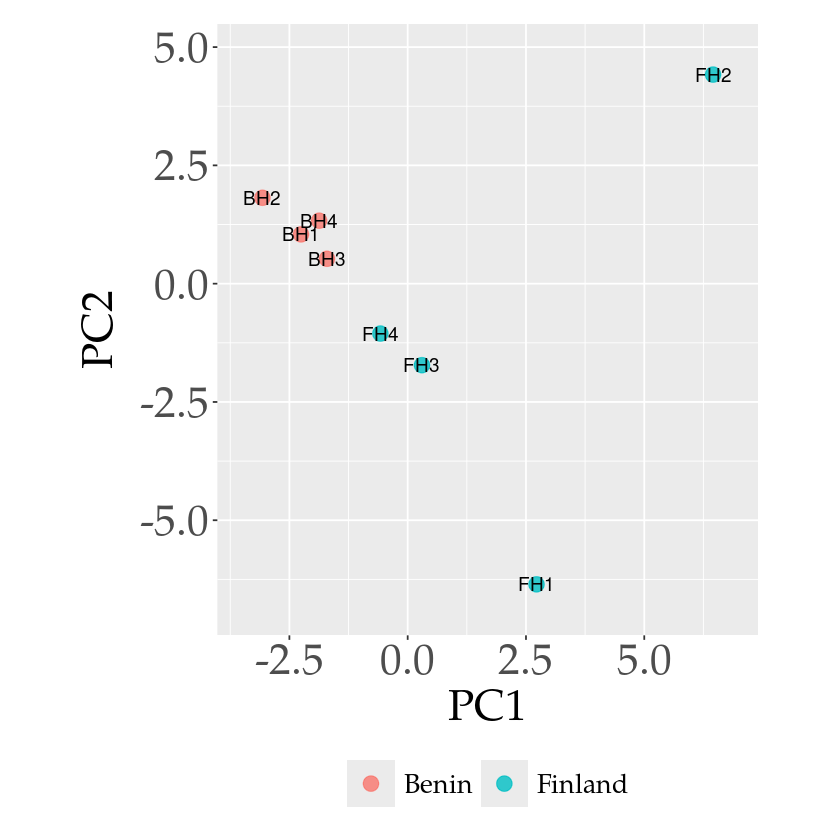

In [45]:
p <- ggplot(pca_data, aes(x = PC1, y = PC2, label = SampleID, group = country)) +
  geom_point(aes(color = country), size = 4, alpha = 0.8) + 
  geom_text(size = 4) +  
  coord_fixed(ratio = 1) +  # Ensures equal scaling for x and y axes
  theme(text = element_text(family = "Palatino"),
        legend.title = element_blank(),
        legend.text = element_text(size = 16),
        legend.key.size = unit(1, 'cm'),
        legend.position = "bottom",
        legend.background = element_rect(color = "#ffffff"),
        legend.direction = "horizontal",
        axis.text.x = element_text(size = 26, angle = 0, hjust = 0.5),
        axis.text.y = element_text(size = 26),
        axis.title.x = element_text(size = 26),                       
        axis.title.y = element_text(size = 26),  
        plot.margin = unit(c(0.5, 0.5, 0.5, 0.5), "cm")) +
  scale_x_continuous(expand = expansion(mult = c(0.1, 0.1))) +  # Adds 10% padding
  scale_y_continuous(expand = expansion(mult = c(0.1, 0.1)))    # Adds 10% padding

print(p)

## Discussions

- The steps above can be repeated for MetaPhlAn abundances. Do you see any differences in the results?
- What other statistical analyis can we perform? 